# 导入相关软件包

In [19]:
import os
import random
import sys

import pandas as pd
from collections import defaultdict
from itertools import combinations
import time
import matplotlib.pyplot as plt

# 参数配置

In [2]:
config_para = {
    'data_path':'../shared_datasets/Groceries_dataset.csv',
    
    'seed':42,
}

In [3]:
# 随机种子
def seed_pytorch(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

In [4]:
seed_pytorch(config_para['seed'])

# 数据读入、加载和处理

In [5]:
# 读取数据
df = pd.read_csv(config_para['data_path'])
df = pd.DataFrame(df)
df

,Member_number,Date,itemDescription
0,1808,21-07-2015,tropical fruit
1,2552,05-01-2015,whole milk
2,2300,19-09-2015,pip fruit
3,1187,12-12-2015,other vegetables
4,3037,01-02-2015,whole milk
...,...,...,...
38760,4471,08-10-2014,sliced cheese
38761,2022,23-02-2014,candy
38762,1097,16-04-2014,cake bar
38763,1510,03-12-2014,fruit/vegetable juice


In [6]:
# 基本信息
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38765 entries, 0 to 38764
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Member_number    38765 non-null  int64 
 1   Date             38765 non-null  object
 2   itemDescription  38765 non-null  object
dtypes: int64(1), object(2)
memory usage: 908.7+ KB


In [7]:
# 去掉时间，将dataframe转换为每个customer的购物记录，作为transaction list
transactions = df.groupby('Member_number')['itemDescription'].apply(list).tolist()

In [8]:
transactions

[['soda',
  'canned beer',
  'sausage',
  'sausage',
  'whole milk',
  'whole milk',
  'pickled vegetables',
  'misc. beverages',
  'semi-finished bread',
  'hygiene articles',
  'yogurt',
  'pastry',
  'salty snack'],
 ['frankfurter',
  'frankfurter',
  'beef',
  'sausage',
  'whole milk',
  'soda',
  'curd',
  'white bread',
  'whole milk',
  'soda',
  'whipped/sour cream',
  'rolls/buns'],
 ['tropical fruit',
  'butter milk',
  'butter',
  'frozen vegetables',
  'sugar',
  'specialty chocolate',
  'whole milk',
  'other vegetables'],
 ['sausage',
  'root vegetables',
  'rolls/buns',
  'detergent',
  'frozen meals',
  'rolls/buns',
  'dental care',
  'rolls/buns'],
 ['other vegetables',
  'pip fruit',
  'root vegetables',
  'canned beer',
  'rolls/buns',
  'whole milk',
  'other vegetables',
  'hygiene articles',
  'whole milk',
  'whole milk',
  'frozen fish',
  'red/blush wine',
  'chocolate',
  'shopping bags',
  'dish cleaner',
  'packaged fruit/vegetables',
  'tropical fruit',
 

# Apriori算法实现

In [20]:
class AprioriAlgorithm:
    def __init__(self, min_support, min_confidence):
        self.min_support = min_support
        self.min_confidence = min_confidence
        self.frequent_itemsets = {}  # 存储频繁项集， {k: {itemset: support}}
        self.rules = []  # 存储关联规则，[(left, right, support, confidence)]
    
    # 计算支持度
    def get_support(self, itemset, transactions):
        count = 0
        for transaction in transactions:
            if itemset.issubset(transaction):
                count += 1
        return count / len(transactions)
    
    # 计算置信度
    def get_confidence(self, left, right, itemset):
        return self.frequent_itemsets[len(itemset)][itemset] / self.frequent_itemsets[len(left)][left]
    
    # 生成频繁1项集
    def generate_frequent_1_itemsets(self, transactions):
        self.frequent_itemsets[1] = {} 
        
        # 使用Counter来高效统计1项集的频次
        from collections import Counter
        item_counts = Counter()
        for transaction in transactions:
            item_counts.update(frozenset([item]) for item in transaction)
        
        # 计算支持度并筛选，得到最终的频繁1项集
        n = len(transactions)
        for item, count in item_counts.items():
            support = count / n
            if support >= self.min_support:
                self.frequent_itemsets[1][item] = support
    
    # 生成频繁k项集
    def generate_frequent_k_itemsets(self, transactions, k):
        # 从k-1项集中生成候选k项集
        candidates = set()
        prev_frequent = list(self.frequent_itemsets[k-1].keys())
        
        # 只连接具有相同k-2项的频繁k-1项集
        for i in range(len(prev_frequent)):
            for j in range(i+1, len(prev_frequent)):
                items1 = set(prev_frequent[i])
                items2 = set(prev_frequent[j])
                if len(items1.union(items2)) == k:
                    candidates.add(frozenset(items1.union(items2)))
        
        # 计算支持度并筛选
        current_frequent = {}
        for transaction in transactions:
            transaction_set = set(transaction)
            for candidate in candidates:
                if candidate.issubset(transaction_set):
                    current_frequent[candidate] = current_frequent.get(candidate, 0) + 1
        
        # 转换为支持度并筛选
        n = len(transactions)
        self.frequent_itemsets[k] = {
            itemset: count/n for itemset, count in current_frequent.items()
            if count/n >= self.min_support
        }
    
    # 生成所有频繁项集
    def get_frequent_itemsets(self, transactions):
        self.generate_frequent_1_itemsets(transactions)  # 1项
        
        # 迭代生成频繁k项集，直到没有更多的频繁项集（为空）
        k = 2
        while k-1 in self.frequent_itemsets and self.frequent_itemsets[k-1]:
            self.generate_frequent_k_itemsets(transactions, k)
            k += 1
    
    # 生成关联规则的pipeline
    def generate_rules(self):
        # 遍历所有频繁项集（k >= 2）
        for k in range(2, len(self.frequent_itemsets) + 1):
            for itemset in self.frequent_itemsets[k].keys():
                
                # 对每个频繁项集，生成所有可能的规则
                for i in range(1, k):
                    for left in combinations(itemset, i):  # 生成所有可能的左项
                        left = frozenset(left)
                        right = itemset - left  # 右项直接减去就行
                        
                        # 计算conf，进行筛选，符合条件的存进最终的rules表里
                        confidence = self.get_confidence(left, right, itemset)
                        if confidence >= self.min_confidence:
                            support = self.frequent_itemsets[k][itemset]
                            self.rules.append((left, right, support, confidence))
                            
                            
    # 计算空间大小（由LLM生成）
    def get_memory_usage(self):
        
        # 计算频繁项集占用的空间
        itemsets_size = 0
        for k, itemsets in self.frequent_itemsets.items():
            # 每个项集的大小 = 项集中元素个数 * 每个元素的大小
            for itemset in itemsets:
                itemsets_size += sys.getsizeof(itemset)
            # 加上支持度值的大小（float类型）
            itemsets_size += len(itemsets) * sys.getsizeof(0.0)
        
        # 计算关联规则占用的空间
        rules_size = 0
        for rule in self.rules:
            # 左项、右项、支持度、置信度
            rules_size += sys.getsizeof(rule[0])  # 左项
            rules_size += sys.getsizeof(rule[1])  # 右项
            rules_size += 2 * sys.getsizeof(0.0)  # 支持度和置信度
        
        return {
            'itemsets_size': itemsets_size / 1024,  # 转换为KB
            'rules_size': rules_size / 1024,
            'total_size': (itemsets_size + rules_size) / 1024
        }

# 实验过程

In [41]:
# 实验参数
min_sup_values = [0.05, 0.075, 0.1]
min_conf_values = [0.2, 0.3, 0.4]

# 用来存结果
results = []

## 不同min_sup和min_conf的频繁项集和规则

In [42]:
idx = 0
for min_sup in min_sup_values:
    for min_conf in min_conf_values:
        idx = idx+1
        print(f"\n测试{idx}：min_sup={min_sup}, min_conf={min_conf}")
        
        # 运行算法
        start_time = time.time()
        # 初始化
        apriori = AprioriAlgorithm(min_sup, min_conf)
        apriori.get_frequent_itemsets(transactions)
        apriori.generate_rules()
        run_time = time.time() - start_time
        
        # 计算空间使用
        memory_usage = apriori.get_memory_usage()
        
        # 记录结果
        results.append({
            'min_support': min_sup,
            'min_confidence': min_conf,
            'run_time': run_time,
            'num_frequent_itemsets': sum(len(x) for x in apriori.frequent_itemsets.values()),
            'num_rules': len(apriori.rules),
            'memory_itemsets': memory_usage['itemsets_size'],
            'memory_rules': memory_usage['rules_size'],
            'memory_total': memory_usage['total_size']
        })
        
        # 输出部分规则
        print("\n发现的规则（每次十条）：")
        for left, right, sup, conf in apriori.rules[:10]:
            print(f"{set(left)} -> {set(right)}")
            print(f"支持度: {sup:.3f}, 置信度: {conf:.3f}")


测试1：min_sup=0.05, min_conf=0.2

发现的规则（每次十条）：
{'yogurt'} -> {'whole milk'}
支持度: 0.151, 置信度: 0.440
{'whole milk'} -> {'yogurt'}
支持度: 0.151, 置信度: 0.235
{'yogurt'} -> {'soda'}
支持度: 0.097, 置信度: 0.285
{'soda'} -> {'yogurt'}
支持度: 0.097, 置信度: 0.251
{'canned beer'} -> {'soda'}
支持度: 0.055, 置信度: 0.297
{'canned beer'} -> {'whole milk'}
支持度: 0.087, 置信度: 0.474
{'sausage'} -> {'whole milk'}
支持度: 0.107, 置信度: 0.451
{'canned beer'} -> {'yogurt'}
支持度: 0.052, 置信度: 0.282
{'sausage'} -> {'soda'}
支持度: 0.077, 置信度: 0.326
{'pastry'} -> {'yogurt'}
支持度: 0.058, 置信度: 0.288

测试2：min_sup=0.05, min_conf=0.3

发现的规则（每次十条）：
{'yogurt'} -> {'whole milk'}
支持度: 0.151, 置信度: 0.440
{'canned beer'} -> {'whole milk'}
支持度: 0.087, 置信度: 0.474
{'sausage'} -> {'whole milk'}
支持度: 0.107, 置信度: 0.451
{'sausage'} -> {'soda'}
支持度: 0.077, 置信度: 0.326
{'pastry'} -> {'soda'}
支持度: 0.063, 置信度: 0.313
{'sausage'} -> {'yogurt'}
支持度: 0.075, 置信度: 0.318
{'pastry'} -> {'whole milk'}
支持度: 0.091, 置信度: 0.452
{'soda'} -> {'whole milk'}
支持度: 0.151, 置信度: 0.3

## 不同min_sup和min_conf的算法运行时间和空间的数据结果和分析

In [43]:
# 使用可视化的方法

In [44]:
# 转换为DataFrame，方便输出
results_df = pd.DataFrame(results)

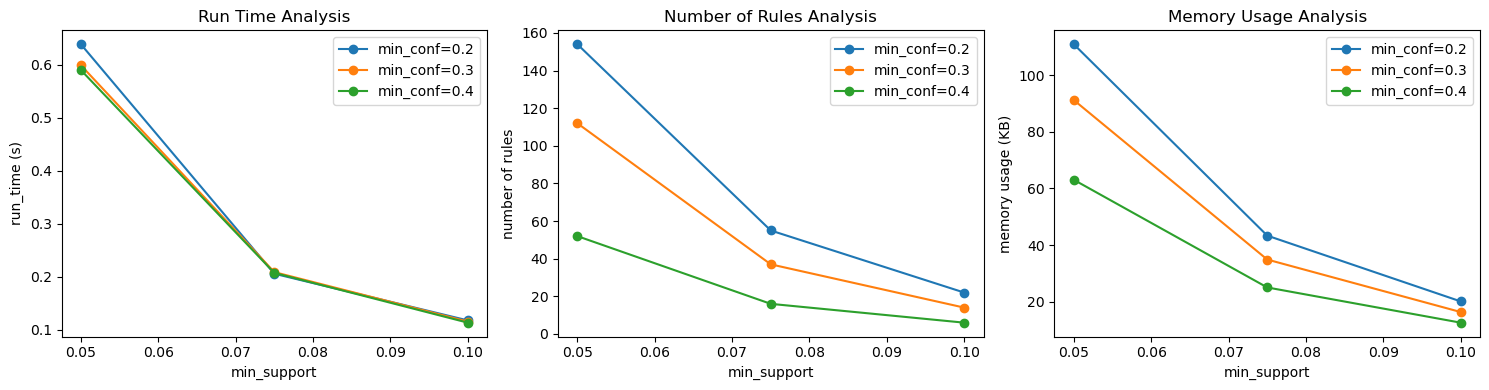

In [45]:
plt.figure(figsize=(15, 4))

# 执行时间
plt.subplot(1, 3, 1)
for conf in min_conf_values:
    data = results_df[results_df['min_confidence'] == conf]
    plt.plot(data['min_support'], data['run_time'], 'o-', label=f'min_conf={conf}')
plt.xlabel('min_support')
plt.ylabel('run_time (s)')
plt.title('Run Time Analysis')
plt.legend()

# 规则数量
plt.subplot(1, 3, 2)
for conf in min_conf_values:
    data = results_df[results_df['min_confidence'] == conf]
    plt.plot(data['min_support'], data['num_rules'], 'o-', label=f'min_conf={conf}')
plt.xlabel('min_support')
plt.ylabel('number of rules')
plt.title('Number of Rules Analysis')
plt.legend()

# 空间使用
plt.subplot(1, 3, 3)
for conf in min_conf_values:
    data = results_df[results_df['min_confidence'] == conf]
    plt.plot(data['min_support'], data['memory_total'], 'o-', label=f'min_conf={conf}')
plt.xlabel('min_support')
plt.ylabel('memory usage (KB)')
plt.title('Memory Usage Analysis')
plt.legend()

plt.tight_layout()
plt.show()